In [55]:
import importlib
import models 
import train
import tokenization
import dataset
import evals 
import graphs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
path = "C:/Users/MrJoker\Desktop/Clinical Data generation/data"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv(f"{path}/synthetic_biomarkers.csv", index_col=0)
df_missing = pd.read_csv(f"{path}/synthetic_missing_biomarkers.csv", index_col=0)
columns = df.columns[2:].to_list()

In [27]:
importlib.reload(dataset)
importlib.reload(train)
importlib.reload(evals)
importlib.reload(tokenization)
importlib.reload(graphs)

<module 'graphs' from 'c:\\Users\\MrJoker\\Desktop\\Clinical Data generation\\graphs.py'>

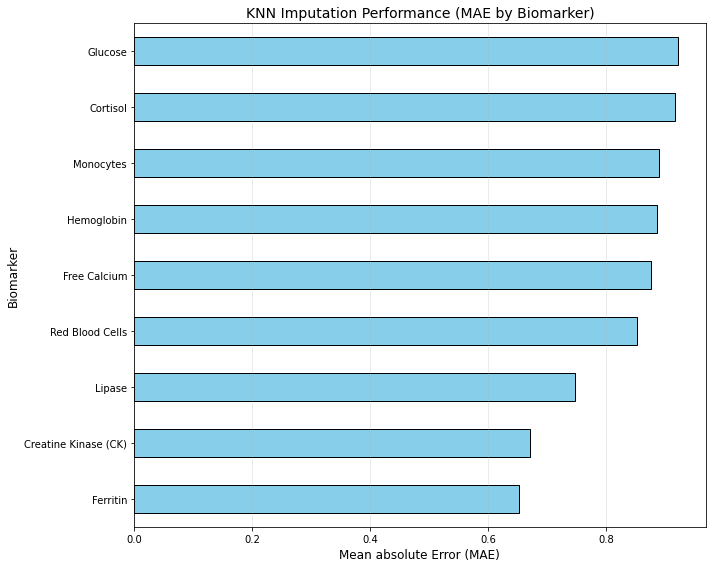

In [3]:
# Baseline KNN Imputation

knn_imputation = models.KNN(neighbors=5, df_missing=df_missing).scaler_imputation()

# Evulation
knn_results = evals.knn_evalutation(knn_imputation=knn_imputation, 
                                    df_original=df, 
                                    df_missing=df_missing, columns= columns)

knn_performance = graphs.plot_knn_performance(knn_results)

In [4]:
# Discrete Transformer Imputation

# Create Bins
binning = tokenization.CreateBins(df=df, columns=columns)
bins = binning.create_bins(q=10)
unique_tokens = binning.create_unique_tokens()

# Tokenizer
tokenizer = tokenization.BiomarkerTokenizer(bin_edges=bins)
tokenizer.build_vocab(unique_tokens)
sequences = tokenizer.encode(unique_tokens)

masked_sequence, targets = tokenization.masked_sequence(sequences, tokenizer.mask_id)

In [5]:
# Dataset and Data Loader
discrete_dataset = dataset.BiomarkerDataset(masked_sequences=masked_sequence, targets=targets)
                                           
discrete_dataloader = DataLoader(discrete_dataset, batch_size=64, shuffle=True)

In [ ]:
# Model and Training
discrete_transformer = models.TransformerDiscrete(vocab_size=len(tokenizer.vocab)).to(device)
train_discrete_model = train.train_transformer_discrete(model= discrete_transformer,
                                                        dataloader= discrete_dataloader,
                                                        vocab=tokenizer.vocab,
                                                        device=device,
                                                        epochs=100)

c:\Users\MrJoker\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
100%|██████████| 79/79 [00:01<00:00, 40.64it/s]


Epoch 10, Loss: 4.0064


100%|██████████| 79/79 [00:01<00:00, 42.78it/s]


Epoch 20, Loss: 3.3017


100%|██████████| 79/79 [00:01<00:00, 41.70it/s]


Epoch 30, Loss: 3.1032


100%|██████████| 79/79 [00:02<00:00, 36.35it/s]


Epoch 40, Loss: 2.9845


100%|██████████| 79/79 [00:01<00:00, 42.95it/s]


Epoch 50, Loss: 2.8934


100%|██████████| 79/79 [00:01<00:00, 40.69it/s]


Epoch 60, Loss: 2.7832


100%|██████████| 79/79 [00:02<00:00, 38.35it/s]


Epoch 70, Loss: 2.6730


100%|██████████| 79/79 [00:01<00:00, 43.09it/s]


Epoch 80, Loss: 2.5326


100%|██████████| 79/79 [00:01<00:00, 39.64it/s]


Epoch 90, Loss: 2.4108


100%|██████████| 79/79 [00:01<00:00, 41.48it/s]


Epoch 100, Loss: 2.2578


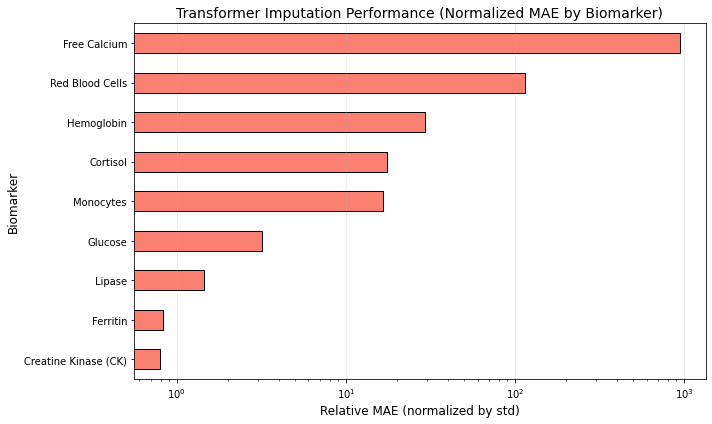

In [29]:
# Model evaulate and visualization
importlib.reload(graphs)
pred_sequences = evals.impute_sequence(model=train_discrete_model,
                                sequences= masked_sequence, 
                                mask_id=tokenizer.mask_id)

discrete_normalised_mae, discrete_normalised_rmse = evals.evaluate_discreteformer(
                                tokenizer=tokenizer, df=df, columns=columns, targets=targets,
                                predicted_sequence=pred_sequences)

discrete_model_performance = graphs.plot_transformer_discrete(normalised_mae=discrete_normalised_mae)

In [10]:
importlib.reload(dataset)
#Regression Transformer Model
x_true, x_masked, masked = models.scale_and_mask(df=df, columns=columns)

# Data and dataloader
continuous_dataset = dataset.BiomarkerDataset(masked_sequences=x_masked, targets=x_true, mask=masked)
continuous_dataloader = DataLoader(continuous_dataset, batch_size=64, shuffle=True)

# Model and Training
regression_model = models.TransformerRegression(num_features=x_masked.shape[1]).to(device)
train_regression = train.train_regression_transformer(model=regression_model,
                                                      dataloader=continuous_dataloader,
                                                      device=device,
                                                      epochs=100)

c:\Users\MrJoker\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 79/79 [00:01<00:00, 72.43it/s]


Epoch 10, Loss: 1.0221


100%|██████████| 79/79 [00:01<00:00, 73.01it/s]


Epoch 20, Loss: 1.0086


100%|██████████| 79/79 [00:01<00:00, 72.90it/s]


Epoch 30, Loss: 0.9772


100%|██████████| 79/79 [00:01<00:00, 76.86it/s]


Epoch 40, Loss: 0.9610


100%|██████████| 79/79 [00:01<00:00, 71.06it/s]


Epoch 50, Loss: 0.9436


100%|██████████| 79/79 [00:01<00:00, 69.94it/s]


Epoch 60, Loss: 0.9297


100%|██████████| 79/79 [00:00<00:00, 84.85it/s]


Epoch 70, Loss: 0.9177


100%|██████████| 79/79 [00:01<00:00, 76.57it/s]


Epoch 80, Loss: 0.9059


100%|██████████| 79/79 [00:01<00:00, 77.59it/s]


Epoch 90, Loss: 0.8990


100%|██████████| 79/79 [00:01<00:00, 78.93it/s]


Epoch 100, Loss: 0.8815


In [ ]:
discrete_mae = pd.Series(discrete_normalised_mae).T.round(4)
knn_mae = pd.Series(knn_results).T.round(4)
biomarkers = continuous_df.loc['Norm_MAE'].index.to_list()

In [49]:
final_results = pd.concat([knn_mae, continuous_df.loc['Norm_MAE'], discrete_mae], axis=1)
final_results.columns = ['KNN', 'Transformer (Regression)', 'Transformer (Discrete)']

In [50]:
final_results

,KNN,Transformer (Regression),Transformer (Discrete)
Cortisol,0.9160,0.1511,17.5469
Creatine Kinase (CK),0.6701,0.0015,0.7951
Ferritin,0.6517,0.0018,0.8262
Free Calcium,0.8757,7.4371,940.8293
Glucose,0.9220,0.0251,3.1958
Hemoglobin,0.8855,0.2503,29.4174
Lipase,0.7463,0.0124,1.4395
Monocytes,0.8885,0.1900,16.4956
Red Blood Cells,0.8520,1.5073,115.0560


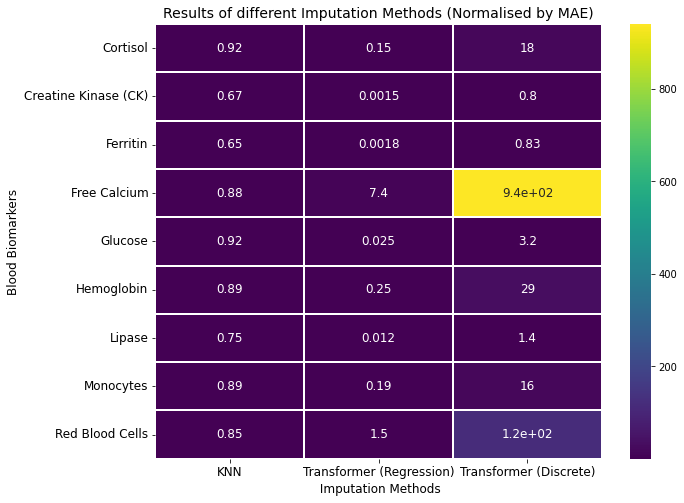

In [65]:
plt.figure(figsize=(10,8))
sns.heatmap(final_results, annot=True, cmap="viridis",linewidths=2, linecolor='white', annot_kws={"fontsize":12})
plt.xlabel(' Imputation Methods', fontsize=12)
plt.ylabel('Blood Biomarkers', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Results of different Imputation Methods (Normalised by MAE)', fontsize=14)
plt.show()